In [1]:
import numpy as np
from jax.experimental import loops
from matplotlib import pyplot as plt
from memory_profiler import profile
import jax.numpy as jnp


## Rectangular box, Equal grid spacing

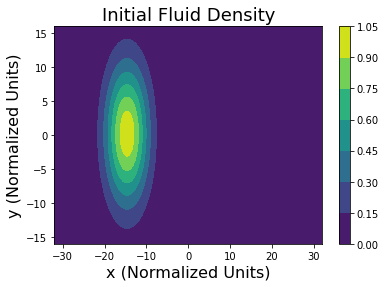

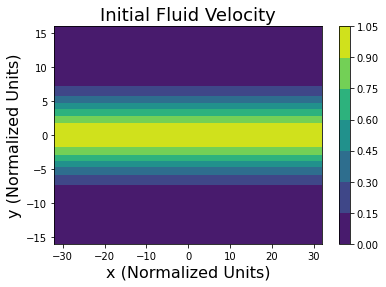

In [2]:
xgrid = np.linspace(-32, 32, nx)
ygrid = np.linspace(-16, 16, ny)

def get_initial_density(xgrid, ygrid):
    xm, ym = np.meshgrid(xgrid, ygrid, indexing="ij")
    x0 = np.random.uniform(0.5*xgrid.min(),0.)
    y0 = np.random.uniform(0.5*ygrid.min(),0.5*ygrid.max())
    xs = 1e-1*np.random.uniform()
    ys = 1e-2*np.random.uniform()
    
    plt.figure()
    initial_density = np.exp(-xs*(xm-x0)**2. - ys*(ym-y0)**2.)
    plt.contourf(xgrid, ygrid, initial_density.T)
    plt.xlabel("x (Normalized Units)", fontsize=16)
    plt.ylabel("y (Normalized Units)", fontsize=16)
    plt.title("Initial Fluid Density", fontsize=18)
    plt.colorbar()
    
    return initial_density


def get_initial_velocity(xgrid, ygrid):
    
    xm, ym = np.meshgrid(xgrid, ygrid, indexing="ij")
    y0 = np.random.uniform(ygrid.min(),ygrid.max())
    ys = 1e-1*np.random.uniform()

    initial_velocity = np.exp(-ys*(ym)**2.)
    plt.figure()
    plt.contourf(xgrid, ygrid, initial_velocity.T)
    plt.xlabel("x (Normalized Units)", fontsize=16)
    plt.ylabel("y (Normalized Units)", fontsize=16)
    plt.title("Initial Fluid Velocity", fontsize=18)
    plt.colorbar()
    
    return initial_velocity

initial_density = get_initial_density(xgrid, ygrid)
initial_velocity = get_initial_velocity(xgrid, ygrid)


## Fluid Advance

In [3]:
dt = 0.1

def get_dndt(velocity, density):
    grad_n = np.gradient(density, axis=0)
    
    return -velocity*grad_n

def run_simulation(initial_density, initial_velocity, dt):
    density_prev = initial_density.copy()

    for i in range(1000):
        density_next = density_prev + dt*get_dndt(velocity=initial_velocity, density=density_prev)
        density_prev = density_next
        
    return density_next

In [4]:
%%timeit
final_density = run_simulation(initial_density, initial_velocity, dt)

286 ms ± 6.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Later Fluid Density')

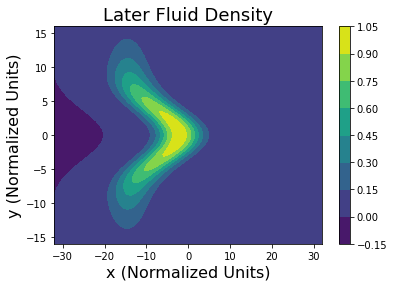

In [5]:
final_density = run_simulation(initial_density, initial_velocity, dt)
plt.contourf(xgrid, ygrid, final_density.T)
plt.colorbar()
plt.xlabel("x (Normalized Units)", fontsize=16)
plt.ylabel("y (Normalized Units)", fontsize=16)
plt.title("Later Fluid Density", fontsize=18)


In [6]:

dt = 0.1

def get_dndt_jax(velocity, density):
    grad_n = jnp.gradient(density, axis=0)
    
    return -velocity*grad_n


def run_simulation_jax(initial_density,initial_velocity, dt):
    density_prev = jnp.array(initial_density)

    for i in range(1000):
        density_next = density_prev + dt*get_dndt(velocity=initial_velocity, density=density_prev)
        density_prev = density_next
        
    return density_next

In [7]:
%%timeit
final_density_jax = run_simulation_jax(initial_density,initial_velocity,  dt)

/Users/archis/Codes/physics/vlajax/venv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


476 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Later Fluid Density')

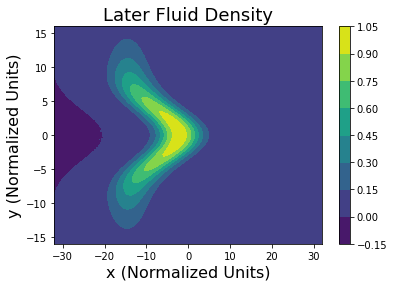

In [8]:
final_density_jax = run_simulation_jax(initial_density,initial_velocity, dt)
plt.contourf(xgrid, ygrid, final_density_jax.T)
plt.colorbar()
plt.xlabel("x (Normalized Units)", fontsize=16)
plt.ylabel("y (Normalized Units)", fontsize=16)
plt.title("Later Fluid Density", fontsize=18)


In [9]:
dt = 0.1

def run_simulation_jax_loops(initial_density, initial_velocity, dt):
    with loops.Scope() as s:
        s.density_prev = jnp.array(initial_density)
        
        for i in range(1000):
            s.grad_n = jnp.gradient(s.density_prev, axis=0)
            s.dndt = -initial_velocity*s.grad_n

            s.density_next = s.density_prev + dt*s.dndt
            s.density_prev = s.density_next
        
    return s.density_next

In [10]:
%%timeit
final_density_jax_loops = run_simulation_jax_loops(initial_density,initial_velocity, dt)

750 ms ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Later Fluid Density')

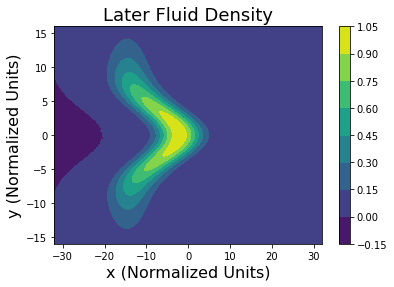

In [11]:
final_density_jax_loops = run_simulation_jax_loops(initial_density,initial_velocity, dt)
plt.contourf(xgrid, ygrid, final_density_jax_loops.T)
plt.colorbar()
plt.xlabel("x (Normalized Units)", fontsize=16)
plt.ylabel("y (Normalized Units)", fontsize=16)
plt.title("Later Fluid Density", fontsize=18)
